### 75.06/95.58 Organización de Datos: Trabajo Práctico 1 ###
#### Primer Cuatrimestre de 2020 ####



In [144]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

tweets = pd.read_csv('train.csv') 
tweets.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [145]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
id          7613 non-null int64
keyword     7552 non-null object
location    5080 non-null object
text        7613 non-null object
target      7613 non-null int64
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [146]:
#Hay tweets repetidos, eliminar?
tweets['text'].describe()

count                                                  7613
unique                                                 7503
top       11-Year-Old Boy Charged With Manslaughter of T...
freq                                                     10
Name: text, dtype: object

In [147]:
tweets['location'].describe()

count     5080
unique    3341
top        USA
freq       104
Name: location, dtype: object

In [148]:
tweets['keyword'].describe()

count           7552
unique           221
top       fatalities
freq              45
Name: keyword, dtype: object

In [149]:
duplicados = tweets.duplicated(subset = 'text', keep = False)
duplicados.value_counts()

False    7434
True      179
dtype: int64

In [150]:
tweets.drop_duplicates(subset = 'text', keep = False, inplace = True)
tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7434 entries, 0 to 7612
Data columns (total 5 columns):
id          7434 non-null int64
keyword     7378 non-null object
location    4982 non-null object
text        7434 non-null object
target      7434 non-null int64
dtypes: int64(2), object(3)
memory usage: 348.5+ KB


#### Top ciudades mentirosas/dicen la verdad #### 

In [346]:
#No me importan las locaciones NAN
partial = tweets.dropna()

In [347]:
partial.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4982 entries, 31 to 7581
Data columns (total 5 columns):
id          4982 non-null int64
keyword     4982 non-null object
location    4982 non-null object
text        4982 non-null object
target      4982 non-null int64
dtypes: int64(2), object(3)
memory usage: 233.5+ KB


In [348]:
locations = partial[partial['location'].str.match(r'^([a-zA-Z,\s])*$') > 0]
locations.head()

,id,keyword,location,text,target
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
33,50,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,53,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,Pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [349]:
locations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 31 to 7581
Data columns (total 5 columns):
id          3946 non-null int64
keyword     3946 non-null object
location    3946 non-null object
text        3946 non-null object
target      3946 non-null int64
dtypes: int64(2), object(3)
memory usage: 185.0+ KB


In [350]:
locations['location'] = locations['location'].str.lower()

/Users/Matias/miniconda2/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [351]:
locations.head()

,id,keyword,location,text,target
31,48,ablaze,birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
33,50,ablaze,africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"philadelphia, pa",Crying out for more! Set me ablaze,0
35,53,ablaze,"london, uk",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [352]:
#10 lugares con mas tweets
top_10_locations = locations['location'].value_counts().nlargest(20).to_frame()
top_10_locations

,location
usa,104
new york,75
united states,50
london,49
canada,33
uk,29
worldwide,29
"los angeles, ca",28
nigeria,25
india,24


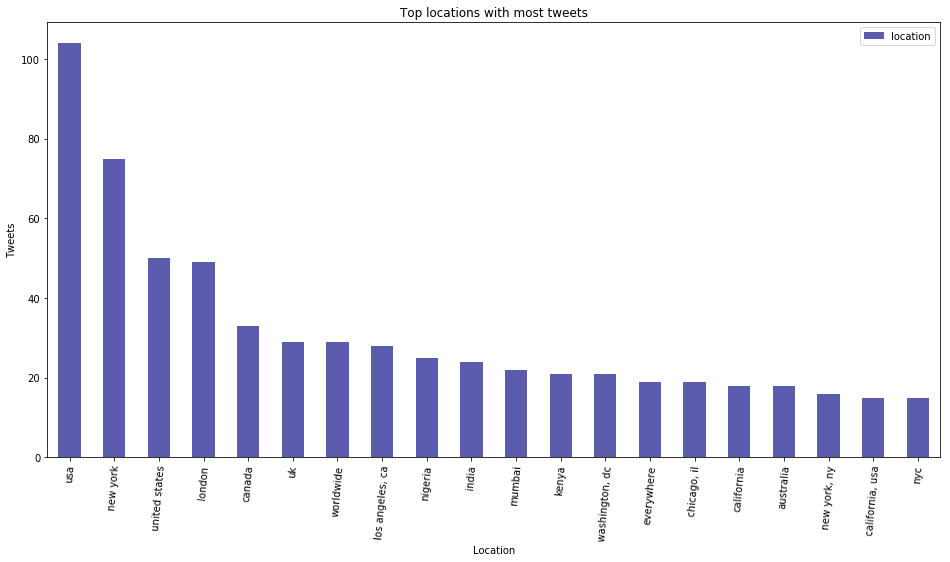

In [353]:
top_10_locations.plot(kind='bar',  rot=85, title='Top locations with most tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Tweets')
ax.set_xlabel('Location')

In [354]:
locations.head()

,id,keyword,location,text,target
31,48,ablaze,birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
33,50,ablaze,africa,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,52,ablaze,"philadelphia, pa",Crying out for more! Set me ablaze,0
35,53,ablaze,"london, uk",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0
36,54,ablaze,pretoria,@PhDSquares #mufc they've built so much hype a...,0


In [355]:
by_location = locations.groupby(['location']).agg({'target':['count', 'sum']})
level_0 = by_location.columns.get_level_values(0)
level_1 = by_location.columns.get_level_values(1)
by_location.columns = level_0 + '_' + level_1
by_location.reset_index(inplace=True)
by_location.head()

,location,target_count,target_sum
0,,1,1
1,glasgow,1,0
2,"melbourne, australia",1,0
3,news,1,1
4,alberta,1,1


In [356]:
by_location.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271 entries, 0 to 2270
Data columns (total 3 columns):
location        2271 non-null object
target_count    2271 non-null int64
target_sum      2271 non-null int64
dtypes: int64(2), object(1)
memory usage: 53.4+ KB


In [357]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="mile.marchese@gmail.com")

from tqdm import tqdm
tqdm.pandas()

from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=2, max_retries=0)
by_location['geodata'] = by_location['location'].progress_apply(geocode)

  0%|          | 9/2271 [00:21<1:45:05,  2.79s/it]RateLimiter swallowed an error after 0 retries. Called with (*(' indiana',), **{}).
Traceback (most recent call last):
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/http/client

 26%|██▌       | 580/2271 [28:52<1:25:41,  3.04s/it]RateLimiter swallowed an error after 0 retries. Called with (*('edinburgh',), **{}).
Traceback (most recent call last):
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 367, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.ge

 26%|██▌       | 589/2271 [29:23<1:34:45,  3.38s/it]RateLimiter swallowed an error after 0 retries. Called with (*('elchilicitanierraversal ',), **{}).
Traceback (most recent call last):
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 367, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_op

 26%|██▋       | 599/2271 [29:57<1:31:57,  3.30s/it]RateLimiter swallowed an error after 0 retries. Called with (*('ely, cambridgeshire',), **{}).
Traceback (most recent call last):
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 367, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
  

 27%|██▋       | 614/2271 [30:47<1:31:22,  3.31s/it]RateLimiter swallowed an error after 0 retries. Called with (*('espoo, finland',), **{}).
Traceback (most recent call last):
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 367, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r =

 27%|██▋       | 622/2271 [31:15<1:29:19,  3.25s/it]RateLimiter swallowed an error after 0 retries. Called with (*('evansville, in',), **{}).
Traceback (most recent call last):
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 367, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r =

 28%|██▊       | 636/2271 [32:02<1:30:43,  3.33s/it]RateLimiter swallowed an error after 0 retries. Called with (*('fct, abuja ',), **{}).
Traceback (most recent call last):
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/site-packages/geopy/geocoders/base.py", line 367, in _call_geocoder
    page = requester(req, timeout=timeout, **kwargs)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 526, in open
    response = self._open(req, data)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 544, in _open
    '_open', req)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 504, in _call_chain
    result = func(*args)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1361, in https_open
    context=self._context, check_hostname=self._check_hostname)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1321, in do_open
    r = h.

 90%|████████▉ | 2033/2271 [1:41:50<11:52,  2.99s/it]RateLimiter swallowed an error after 0 retries. Called with (*('travelling around the world ',), **{}).
Traceback (most recent call last):
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/urllib/request.py", line 1318, in do_open
    encode_chunked=req.has_header('Transfer-encoding'))
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/http/client.py", line 1239, in request
    self._send_request(method, url, body, headers, encode_chunked)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/http/client.py", line 1285, in _send_request
    self.endheaders(body, encode_chunked=encode_chunked)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/http/client.py", line 1234, in endheaders
    self._send_output(message_body, encode_chunked=encode_chunked)
  File "/Users/Matias/miniconda2/envs/py36/lib/python3.6/http/client.py", line 1026, in _send_output
    self.send(msg)
  File "/Users/Matias/miniconda2/envs/py36/li

100%|██████████| 2271/2271 [1:53:46<00:00,  3.01s/it]


In [358]:
by_location

,location,target_count,target_sum,geodata
0,,1,1,None
1,glasgow,1,0,"(Glasgow, Glasgow City, Scotland, G2 9SA, Unit..."
2,"melbourne, australia",1,0,"(City of Melbourne, Victoria, Australia, (-37...."
3,news,1,1,"(34375, Abbotsford Centre, Abbotsford, Fraser ..."
4,alberta,1,1,"(Alberta, Canada, (55.001251, -115.002136))"
...,...,...,...,...
2266,zac newsome loves me,1,0,None
2267,"zeerust, south africa",1,0,"(Zeerust, Ngaka Modiri Molema District Municip..."
2268,zero branco,1,0,"(Zero Branco, Treviso, Veneto, 31059, Italia, ..."
2269,ziam af,1,1,None


In [361]:
by_location['address'] = by_location['geodata'].apply(lambda loc: loc.address if loc else None)
by_location['point'] = by_location['geodata'].apply(lambda loc: tuple(loc.point) if loc else None)

In [362]:
by_location.head()

,location,target_count,target_sum,geodata,address,point
0,,1,1,None,None,None
1,glasgow,1,0,"(Glasgow, Glasgow City, Scotland, G2 9SA, Unit...","Glasgow, Glasgow City, Scotland, G2 9SA, Unite...","(55.8609825, -4.2488787, 0.0)"
2,"melbourne, australia",1,0,"(City of Melbourne, Victoria, Australia, (-37....","City of Melbourne, Victoria, Australia","(-37.8142176, 144.9631608, 0.0)"
3,news,1,1,"(34375, Abbotsford Centre, Abbotsford, Fraser ...","34375, Abbotsford Centre, Abbotsford, Fraser V...","(49.04172215, -122.27255349013137, 0.0)"
4,alberta,1,1,"(Alberta, Canada, (55.001251, -115.002136))","Alberta, Canada","(55.001251, -115.002136, 0.0)"


In [363]:
by_location.to_csv('locations.csv', index=False)

In [364]:
address = pd.read_csv('locations.csv', usecols=['location', 'target_count', 'target_sum', 'address']) 
address.head()

,location,target_count,target_sum,address
0,,1,1,NaN
1,glasgow,1,0,"Glasgow, Glasgow City, Scotland, G2 9SA, Unite..."
2,"melbourne, australia",1,0,"City of Melbourne, Victoria, Australia"
3,news,1,1,"34375, Abbotsford Centre, Abbotsford, Fraser V..."
4,alberta,1,1,"Alberta, Canada"


In [365]:
#Hay 374 que geopy no encontró
address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2271 entries, 0 to 2270
Data columns (total 4 columns):
location        2271 non-null object
target_count    2271 non-null int64
target_sum      2271 non-null int64
address         1880 non-null object
dtypes: int64(2), object(2)
memory usage: 71.1+ KB


In [373]:
#Se puede correr de nuevo geopy 
not_found_addr = address[address['address'].isnull()]
not_found_addr.head()

,location,target_count,target_sum,address
0,,1,1,NaN
8,indiana,1,0,NaN
9,jariana town,1,0,NaN
12,"nevada carson city,freeman st",1,1,NaN
16,nxgerxa,1,0,NaN


In [374]:
address['address'].describe()

count                                   1880
unique                                  1430
top       New York, United States of America
freq                                      15
Name: address, dtype: object

In [385]:
by_address = address.groupby(['address']).agg({'target_count':'sum', 'target_sum': 'sum'\
                                               , 'location': lambda x: "%s" % '-'.join(set(x))}).reset_index()
by_address.head()

,address,target_count,target_sum,location
0,"(B-40);Terrassa nord;Matadepera, Autopista Bar...",1,0,prov
1,"1, Route Y, Lede, Ripley County, Missouri, 639...",1,1,im in route
2,"1, South Rent Car Road, East Haven, Houston, H...",1,1,in the shadows
3,"188, Շահումյան փողոց, Գյումրի, Շիրակի մարզ, 31...",1,0,a sofa
4,"2551, Woodcreek Oaks Boulevard, Roseville, Pla...",1,0,"woodcreek hs, roseville, ca"


In [386]:
by_address.columns = ['address', 'total', 'real', 'location_list']

In [408]:
by_address['fake'] = by_address['total'] - by_address['real']
by_address.head()

,address,total,real,location_list,fake
0,"(B-40);Terrassa nord;Matadepera, Autopista Bar...",1,0,prov,1
1,"1, Route Y, Lede, Ripley County, Missouri, 639...",1,1,im in route,0
2,"1, South Rent Car Road, East Haven, Houston, H...",1,1,in the shadows,0
3,"188, Շահումյան փողոց, Գյումրի, Շիրակի մարզ, 31...",1,0,a sofa,1
4,"2551, Woodcreek Oaks Boulevard, Roseville, Pla...",1,0,"woodcreek hs, roseville, ca",1


In [409]:
by_address.describe()

,total,real,fake
count,1430.000000,1430.000000,1430.000000
mean,2.461538,1.100699,1.360839
std,7.133800,3.632477,3.987893
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,1.000000,1.000000
max,168.000000,103.000000,98.000000


In [410]:
#10 ciudades que mas reales tienen
most_real = by_address.nlargest(10, 'real').loc[:, ['address', 'real']].set_index('address')
most_real

,real
address,
United States,103
"New York, United States of America",40
"London, Greater London, England, SW1A 2DX, United Kingdom",26
"Mumbai, Mumbai City, Maharashtra, India",22
Nigeria,22
United Kingdom,20
"Washington, District of Columbia, 20500, United States of America",19
भारत - India,19
"Calgary, Alberta, Canada",18


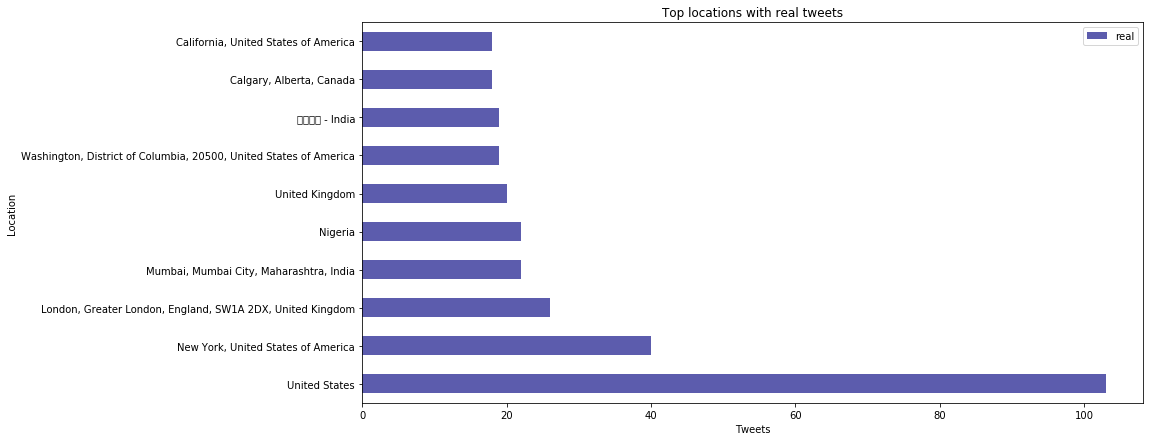

In [441]:
most_real.plot(kind='barh',  rot=0, title='Top locations with real tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(14, 7))
ax = plt.gca()
ax.set_xlabel('Tweets')
ax.set_ylabel('Location')

In [414]:
#10 ciudades que mas falsos tienen
most_fake = by_address.nlargest(10, 'fake').loc[:,['address', 'fake']].set_index('address')
most_fake

,fake
address,
"New York, United States of America",98
United States,65
"London, Greater London, England, SW1A 2DX, United Kingdom",49
"Los Angeles, Los Angeles County, California, United States of America",32
"California, United States of America",24
United Kingdom,24
Canada,20
"Texas, United States of America",20
"Chicago, Cook County, Illinois, United States of America",19


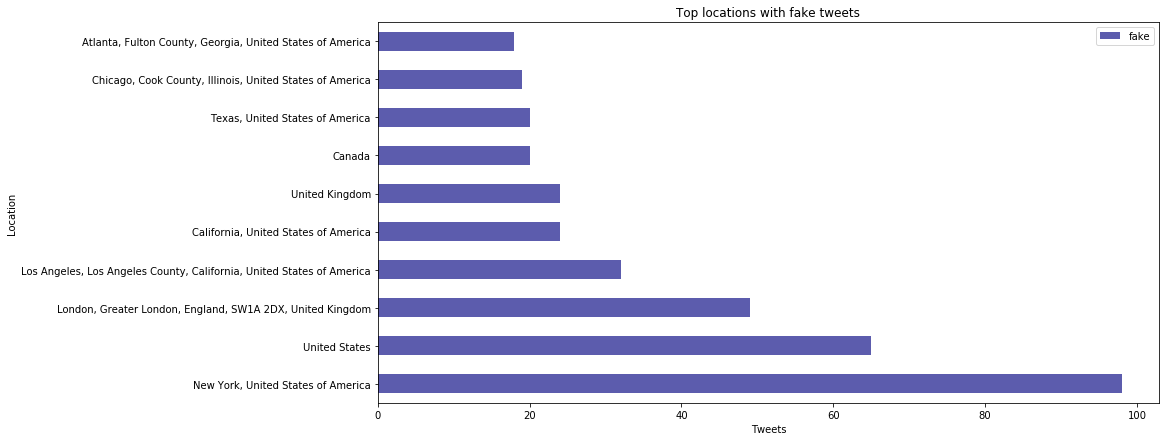

In [444]:
most_fake.plot(kind='barh',  rot=0, title='Top locations with fake tweets', color=(0.2, 0.2, 0.6, 0.8), figsize=(14, 7))
ax = plt.gca()
ax.set_xlabel('Tweets')
ax.set_ylabel('Location')

In [424]:
by_address.describe()

,total,real,fake
count,1430.000000,1430.000000,1430.000000
mean,2.461538,1.100699,1.360839
std,7.133800,3.632477,3.987893
min,1.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000
75%,2.000000,1.000000,1.000000
max,168.000000,103.000000,98.000000


#### Palabras y expresiones mas usadas en tweets, no importa real or fake.

In [425]:
tweets[tweets['text'].str.contains('cool')]

,id,keyword,location,text,target
21,32,NaN,NaN,London is cool ;),0
625,899,bioterrorism,NaN,CDC has a pretty cool list of all bioterrorism...,1
751,1083,blew%20up,Indiana,My Instagram just blew up apparently I was fea...,0
812,1179,blizzard,NaN,What if every 5000 wins in ranked play gave yo...,0
1283,1851,burned,"Escondido, CA",I just remembered the McDonald's that burned d...,0
1333,1925,burning%20buildings,please H? ?:??,the mv should just be them strutting like they...,1
1442,2078,casualty,"Trinity, Bailiwick of Jersey",@ScriptetteSar @katiecool447 btw the 30th is a...,1
1471,2119,catastrophe,"los angeles, ca",Then the stylist who'd been silent says 'there...,0
1597,2306,collapse,"Highland Park, CA",Time collapse is such a cool video technique. ...,0
1659,2396,collapsed,wherever-the-fuck washington,@flickershowell oh wow my heart collapsed cool...,1


#### Personas mas mencionadas

In [426]:
tweets_with_mentions = tweets.loc[tweets['text'].str.contains('@'), ['text', 'target']]
mentions = tweets_with_mentions['text'].str.findall(r'@.\S*?(?=\s|[:]|$)').to_frame()
#La regex encuentra todas las palabras que empiecen con '@' y al mismo tiempo elimina los '@:' y '@ '
#El arroba se usa como expresion para indicar la hora tambien

In [428]:
mentions.head()

,text
31,[@bbcmtd]
36,[@PhDSquares]
43,[@southridgelife]
54,[@Alexis_Sanchez]
57,[@Û_]


In [430]:
mentions['target'] = tweets_with_mentions['target']

In [431]:
mentions.head()

,text,target
31,[@bbcmtd],1
36,[@PhDSquares],0
43,[@southridgelife],0
54,[@Alexis_Sanchez],0
57,[@Û_],0


In [432]:
mentions_to_group = mentions.explode('text')

In [433]:
mentions_to_group.head()

,text,target
31,@bbcmtd,1
36,@PhDSquares,0
43,@southridgelife,0
54,@Alexis_Sanchez,0
57,@Û_,0


In [435]:
mentions_grouped = mentions_to_group.groupby(['text']).agg({'text': 'count', 'target':'sum'}).nlargest(20, 'text')
mentions_grouped['fake'] = mentions_grouped['text'] - mentions_grouped['target']
mentions_grouped.columns = ['total', 'real', 'fake']

In [436]:
mentions_grouped.head()

,total,real,fake
text,,,
@YouTube,82,17,65
@ArianaGrande,11,0,11
@Change,9,4,5
@FoxNews,9,8,1
@POTUS,9,6,3


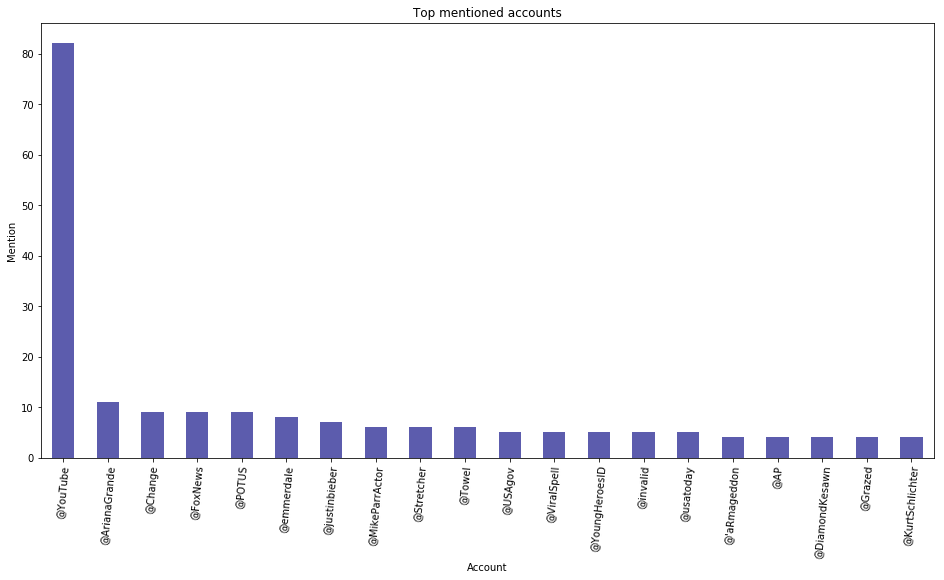

In [437]:
mentions_grouped.loc[:, 'total'].plot(kind='bar',  rot=85, title='Top mentioned accounts', color=(0.2, 0.2, 0.6, 0.8), figsize=(16, 8))
ax = plt.gca()
ax.set_ylabel('Mention')
ax.set_xlabel('Account')

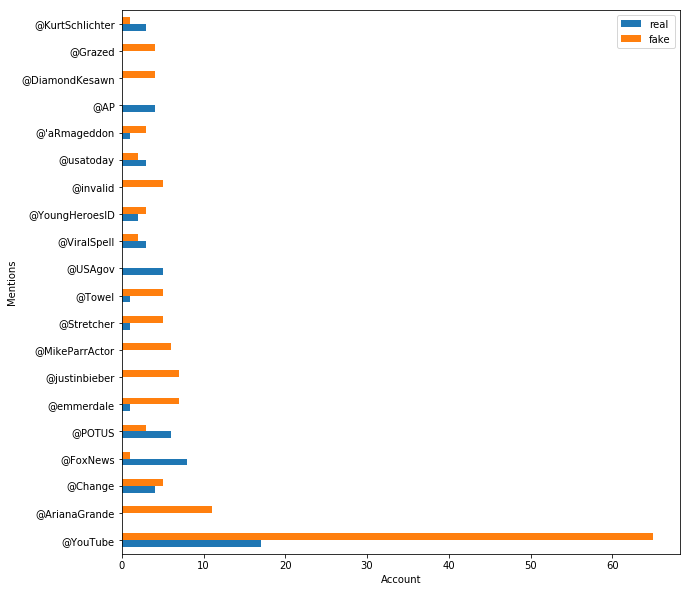

In [438]:
ax = mentions_grouped.loc[:, ['real', 'fake']].plot(kind='barh', figsize=(10, 10))
ax.set_ylabel('Mentions')
ax.set_xlabel('Account')